## Setup

In [37]:
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import transforms, datasets

In [38]:
# from zipfile import ZipFile

# with ZipFile('ffhq-face-data-set.zip', 'r') as f:
#     f.extractall('/workspace/dn/ffhq-face-data-set')
    

In [39]:
torch.cuda.is_available()

True

In [46]:
device  = torch.device('cuda')
PATH = '/kaggle/input/ffhq-face-data-set/'



In [47]:
def imshow(image, ax=None, title=None, normalize=False):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std*image+mean
        image=np.clip(image, 0, 1)
        
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

## Dataset

In [48]:
transform = transforms.Compose([transforms.Resize(255), transforms.ToTensor()])
dataset = datasets.ImageFolder(PATH, transform = transform)

X, y = random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
xDataLoader = torch.utils.data.DataLoader(X, batch_size=16, shuffle=True)
yDataLoader = torch.utils.data.DataLoader(y, batch_size=16, shuffle=True)

torch.Size([3, 255, 255])

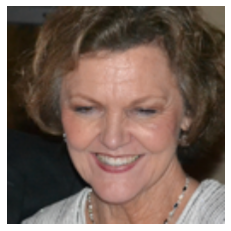

In [49]:
images, _ = next(iter(yDataLoader))
imshow(images[1])
images[1].shape

## Add noise

<AxesSubplot:>

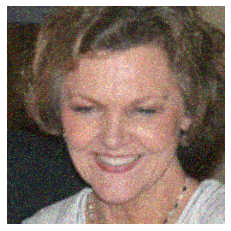

In [50]:
# poisson noise
def addPoissonNoise(images):
	p = torch.poisson(0.5*torch.ones(images.shape))
	noise = p*0.8/p.max()
	noisyImages = (images + noise).clip(0, 1)
	return noisyImages
noisyImages = addPoissonNoise(images)
imshow(noisyImages[1])

## Evaluation parameters

In [51]:
EPS = 1e-8

In [52]:
def mseOf(input, target):
	mse = torch.mean((input-target)**2, dim=[1, 2, 3])
	return mse

In [53]:
def psnrOf(input, target):
	psnr = -10*torch.log10(mseOf(input, target))+EPS
	return psnr

In [54]:
print(f"psnr of noisy images {psnrOf(images, noisyImages)}")

psnr of noisy images tensor([20.4604, 20.1401, 20.3267, 21.7360, 20.3741, 20.4323, 20.2448, 20.4200,
        20.1350, 21.1952, 20.5575, 20.4306, 20.4756, 20.1891, 20.8264, 20.3273])


## Autoencoders

In [55]:
class Autoencoders(nn.Module):
	def __init__(self):
		super(Autoencoders, self).__init__()

		self.Encoder = nn.Sequential(
			# 32 -> 3 (planned for removal)
			nn.Conv2d(3, 32, kernel_size=(3, 3), padding='same'),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),

			nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),

			nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same'),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),

			# nn.Conv2d(128, 224, kernel_size=(3, 3)),
			# nn.ReLU(),
			# nn.MaxPool2d((3,3))
		)


		self.Decoder = nn.Sequential(
			# nn.ConvTranspose2d(224, 224, kernel_size=(3,3)),

			nn.ConvTranspose2d(128, 128, kernel_size=(3,3), stride=2, padding=0),
			nn.ReLU(),

			nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=2, padding=0),
			nn.ReLU(),

			nn.ConvTranspose2d(64, 32, kernel_size=(3,3), stride=2, padding=0),
			nn.ReLU(),

			# 3 -> 32 (planned for removal)
			nn.ConvTranspose2d(32, 3, kernel_size=(3,3), stride=1, padding=1),
			nn.Sigmoid()
		)

	def forward(self, images):
		x = self.Encoder(images)
		# print(x.shape)
		x = self.Decoder(x)
		# print(x.shape)
		return x

In [56]:
# class Autoencoder(nn.Module):
# 	def __init__(self):
# 		super(Autoencoder,self).__init__()
# 		self.encoder = nn.Sequential(
# 			nn.Conv2d(3, 6, kernel_size=5),
# 			nn.ReLU(True),
# 			nn.Conv2d(6,16,kernel_size=5),
# 			nn.ReLU(True))
# 		self.decoder = nn.Sequential(
# 			nn.ConvTranspose2d(16,6,kernel_size=5),
# 			nn.ReLU(True),
# 			nn.ConvTranspose2d(6,3,kernel_size=5),
# 			nn.ReLU(True))
	
# 	def forward(self,x):
# 		x = self.encoder(x)
# 		x = self.decoder(x)
# 		print(x.shape)
		
# 		return x

In [57]:
print(Autoencoders(), torch.zeros((1, 3, 255, 255)))
# mod = Autoencoders()
# ou=mod(torch.zeros((1, 3, 128, 128)))

Autoencoders(
  (Encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
) tensor([[[[0., 0., 0

In [58]:
loss_module = nn.MSELoss()
# plan for removal if trainModel works

In [59]:
def evaluate(model, validationDataLoader):
	model.eval()
	psnr, mse = [], []

	with torch.no_grad():
		for images, _ in validationDataLoader:
			noisyImages = addPoissonNoise(images)

			images = images.to(device)
			noisyImages = noisyImages.to(device)

			preds = model(images)
			psnr.extend(psnrOf(images.cpu().detach(), preds.cpu().detach()) )
			mse.extend(mseOf(images.cpu().detach(), preds.cpu().detach()))
		
		print(f'PSNR => mean:{np.array(psnr).mean()} | std:{np.array(psnr).std()}')
		print(f'MSE => mean:{np.array(mse).mean()} | std:{np.array(mse).std()}')

		return np.array(psnr).mean(), np.array(mse).mean()


In [60]:
def trainModel(model, optimizer, trainDataLoader, validationDataLoader, num_epochs=30):
	loss_module = nn.MSELoss()
	data = {
		'epoch': [],
		'mse_train': [],
		'mse_val': [],
		'psnr_train': [],
		'psnr_val': [],
		'mse': 0.0,
		'psnr': 0.0
	}

	for epoch in range(num_epochs):
		for images, _ in trainDataLoader:
			targets = torch.clone(images)

			noisyImages = addPoissonNoise(images)
			noisyImages = noisyImages.to(device)

			targets = targets.to(device)
			preds = model(noisyImages)
			# print(targets.shape)
			# print(preds.shape)
			# targets=preds.reshape((16,3,22,22))
			loss = loss_module(preds, targets)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

		print(f'----------| EPOCH {epoch+1} |----------\n')
		data['epoch'].append(epoch+1)
		print("Train set: ", end='')
		data['psnr'], data['mse'] = evaluate(model, trainDataLoader)
		data['psnr_train'].append(data['psnr'])
		data['mse_train'].append(data['mse'])

		print("Validation set: ", end='')
		data['psnr'], data['mse'] = evaluate(model, validationDataLoader)
		data['psnr_val'].append(data['psnr'])
		data['mse_val'].append(data['mse'])
			

In [19]:
# ae = Autoencoders()
# optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)
# ae = ae.to(device)

In [20]:
# %%time
# trainModel(ae, optimizer, xDataLoader, yDataLoader, num_epochs=25)

----------| EPOCH 1 |----------



Train set: PSNR => mean:29.47181510925293 | std:1.5729479789733887

MSE => mean:0.0012060758890584111 | std:0.00046010359073989093

Validation set: PSNR => mean:29.473299026489258 | std:1.5960485935211182

MSE => mean:0.0012086398201063275 | std:0.00047569815069437027

----------| EPOCH 2 |----------



Train set: PSNR => mean:31.404333114624023 | std:1.603782296180725

MSE => mean:0.000777467037551105 | std:0.0003278470830991864

Validation set: PSNR => mean:31.393821716308594 | std:1.6340537071228027

MSE => mean:0.0007820025784894824 | std:0.00034326707827858627

----------| EPOCH 3 |----------



Train set: PSNR => mean:31.867929458618164 | std:1.6196823120117188

MSE => mean:0.0006988680688664317 | std:0.00029001347138546407

Validation set: PSNR => mean:31.855865478515625 | std:1.6528081893920898

MSE => mean:0.0007033070432953537 | std:0.0003039009461645037

----------| EPOCH 4 |----------



Train set: PSNR => mean:32.7422981262207 | std:1.619

In [21]:
# torch.save(ae, 'model_state_1')

In [62]:
ae = torch.load('/kaggle/input/kaaaaaa/ka/model_state_1')
ae.eval()

Autoencoders(
  (Encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (Decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

## Results and comparision                              

<AxesSubplot:>

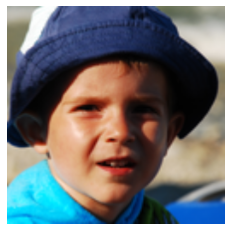

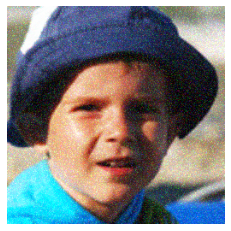

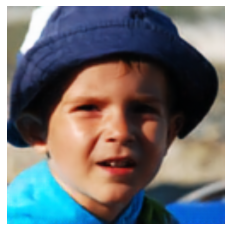

In [63]:
clear = images[0]
imshow(clear)

test = noisyImages[0]
test
imshow(test)

# test = test.to(device)
test = noisyImages.to(device)
testDataLoader = torch.utils.data.DataLoader(test)
test = next(iter(testDataLoader))
output = ae(test)
imshow(output[0].cpu().detach())